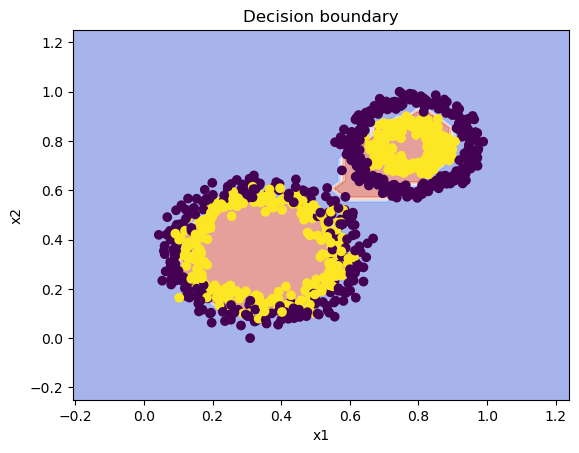

In [1]:
from dice_wrapper import *
from robx import *
from create_data_examples import *
from scikit_models import *
from plot_helpers import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

np.random.seed(222)

# Ignore InconsistentVersionWarning
warnings.filterwarnings("ignore", category=UserWarning)

X_train, y_train = create_two_donuts(n_samples=1000, random_state=0)
X_val, y_val = create_two_donuts(n_samples=500, random_state=1)
X_test, y_test = create_two_donuts(n_samples=500, random_state=2)

train_dataset = pd.DataFrame(np.concatenate([X_train, y_train.reshape(-1, 1)], axis=1), columns=['x1', 'x2', 'y'])
train_dataset['y'] = train_dataset['y'].astype(int)

val_dataset = pd.DataFrame(np.concatenate([X_val, y_val.reshape(-1, 1)], axis=1), columns=['x1', 'x2', 'y'])
val_dataset['y'] = val_dataset['y'].astype(int)

test_dataset = pd.DataFrame(np.concatenate([X_test, y_test.reshape(-1, 1)], axis=1), columns=['x1', 'x2', 'y'])
test_dataset['y'] = test_dataset['y'].astype(int)

model_name = 'mlp'
model = load_model(f'../models/{model_name}.joblib')


plot_crisp_decision_boundary(model, X_val, y_val)

In [2]:
explainer = get_dice_explainer(
    dataset=train_dataset,
    model=model,
    outcome_name='y',
    continous_features=['x1', 'x2'],
    dice_method='random',
)


original_instances = []
counterfactuals = []

for i in range(3):
    cf = get_dice_counterfactuals(
            dice_exp=explainer,
            query_instance=val_dataset.iloc[i:i+1].drop(columns=['y']),
            total_CFs=1,
            proximity_weight=1.0,
            diversity_weight=0.1,
            # desired_class="opposite",
        )
    original_instances.append(val_dataset.iloc[i:i+1].to_numpy()[0])
    counterfactuals.append(cf[0].final_cfs_df.to_numpy()[0])

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


In [3]:
print(original_instances)
print(counterfactuals)

[array([0.41994346, 0.58137208, 1.        ]), array([0.25554954, 0.49508711, 1.        ]), array([0.46285942, 0.60038694, 0.        ])]
[array([0.37021892, 0.58137208, 1.        ]), array([0.95988133, 0.49508711, 0.        ]), array([0.46285942, 0.19416374, 1.        ])]


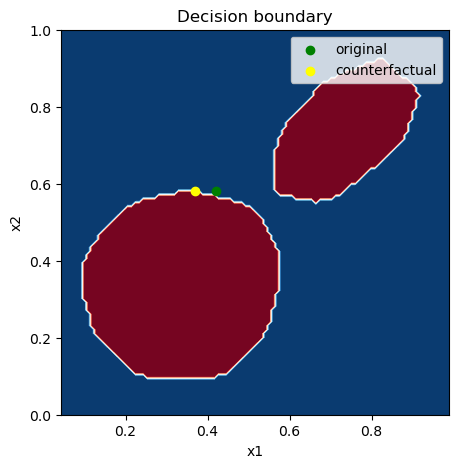

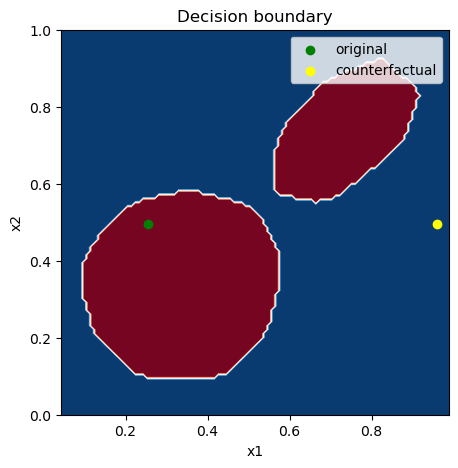

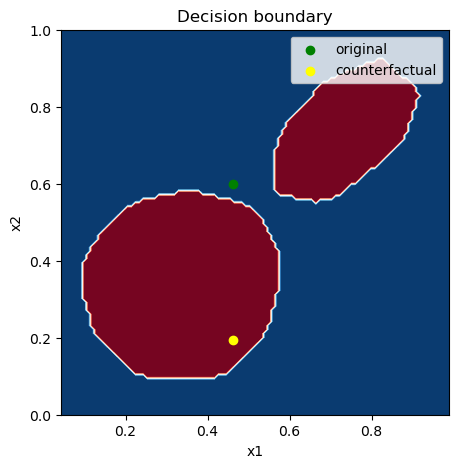

In [4]:


for i in range(3):
    plot_decision_boundary_with_artifacts(
        model=model,
        X=X_val,
        y=y_val,
        artifacts=[
            {'coords': original_instances[i][:2], 'color': 'green', 'marker': 'o', 'label': 'original'},
            {'coords': counterfactuals[i][:2], 'color': 'yellow', 'marker': 'o', 'label': 'counterfactual'},
        ]
    )

original [0]
counterfactual [1]
robust [0]
conservative [array([0]), array([0]), array([0])]
original proba [0.25348128]
counterfactual proba [0.94946859]
robust proba [0.45959603]
conservative proba [array([0.29403604]), array([0.14750804]), array([0.26801959])]


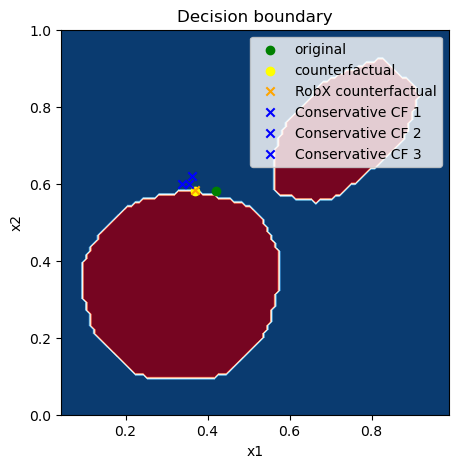

TypeError: 'numpy.float64' object is not iterable

In [5]:
predict_fn = scikit_predict_proba_fn(model)

for i in range(3):

    robust_cf, conservative_cfs = robx_algorithm(
        X_train=X_train,
        predict_class_proba_fn=predict_fn,
        start_counterfactual=counterfactuals[i][:2],
        tau=0.3,
        variance=0.01,
    )
    
    if robust_cf is not None:
        art = [
                {'coords': original_instances[i][:2], 'color': 'green', 'marker': 'o', 'label': 'original'},
                {'coords': counterfactuals[i][:2], 'color': 'yellow', 'marker': 'o', 'label': 'counterfactual'},
                {'coords': robust_cf, 'color': 'orange', 'marker': 'x', 'label': 'RobX counterfactual'}, 
            ]
        for i, cf in enumerate(conservative_cfs):
            art.append({'coords': cf, 'color': 'blue', 'marker': 'x', 'label': f'Conservative CF {i+1}'})
        
        print('original', model.predict(original_instances[i][:2].reshape(1, -1)))    
        print('counterfactual', model.predict(counterfactuals[i][:2].reshape(1, -1)))
        print('robust', model.predict(robust_cf.reshape(1, -1)))
        print('conservative', [model.predict(cf.reshape(1, -1)) for cf in conservative_cfs])
        
        print('original proba', predict_fn(original_instances[i][:2].reshape(1, -1)))
        print('counterfactual proba', predict_fn(counterfactuals[i][:2].reshape(1, -1)))
        print('robust proba', predict_fn(robust_cf.reshape(1, -1)))
        print('conservative proba', [predict_fn(cf.reshape(1, -1)) for cf in conservative_cfs])
        
        
        plot_decision_boundary_with_artifacts(
            model=model,
            X=X_val,
            y=y_val,
            artifacts=art,
        )